In [1]:
import osmnx as ox
import geopandas as gpd
import numpy as npm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
CRS_PLOT = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'
ROUTE = 'b26'

In [3]:
stops_df = pd.read_csv(f'{DATA_DIR}/20210817_stops.txt')
stop_times_df = pd.read_csv(f'{DATA_DIR}/20210817_stop_times.txt')
stop_times_df = stop_times_df.drop(columns=['departure_time', 'pickup_type', 'drop_off_type']).rename(columns={'arrival_time': 'time'})

In [4]:
stop_times_df = stop_times_df[stop_times_df['trip_id'].str.contains(f'_{ROUTE.upper()}_')]
stop_times_df = stop_times_df[stop_times_df['trip_id'].str.contains(f'Weekday')]

In [5]:
trip_ids = stop_times_df.groupby(by=['trip_id']).agg('first')
trip_ids.head()

,time,stop_id,stop_sequence
trip_id,,,
FP_C1-Weekday-009000_B26_201,01:30:00,304417,1
FP_C1-Weekday-013300_B26_201,02:13:00,307175,1
FP_C1-Weekday-017000_B26_201,02:50:00,504965,1
FP_C1-Weekday-020500_B26_201,03:25:00,307175,1
FP_C1-Weekday-027000_B26_201,04:30:00,304417,1


In [6]:
matching_routes_df = stop_times_df[stop_times_df['trip_id'] == trip_ids.index[3]]
matching_routes_df.head()

,trip_id,time,stop_id,stop_sequence
605667,FP_C1-Weekday-020500_B26_201,03:25:00,307175,1
605668,FP_C1-Weekday-020500_B26_201,03:26:07,307699,2
605669,FP_C1-Weekday-020500_B26_201,03:26:35,307426,3
605670,FP_C1-Weekday-020500_B26_201,03:28:03,302445,4
605671,FP_C1-Weekday-020500_B26_201,03:29:05,307491,5


In [7]:
matching_route_trip_ids = list(set(matching_routes_df['trip_id']))
single_route_df = stop_times_df[stop_times_df['trip_id'] == matching_route_trip_ids[0]]
route_stop_first = single_route_df.iloc[0]['stop_id']
route_stop_last = single_route_df.iloc[-1]['stop_id']
route_length = int(single_route_df.iloc[-1]['stop_sequence']) - 1
display(route_stop_first)
display(route_stop_last)
display(route_length)
single_route_df

307175

901502

42

,trip_id,time,stop_id,stop_sequence
605667,FP_C1-Weekday-020500_B26_201,03:25:00,307175,1
605668,FP_C1-Weekday-020500_B26_201,03:26:07,307699,2
605669,FP_C1-Weekday-020500_B26_201,03:26:35,307426,3
605670,FP_C1-Weekday-020500_B26_201,03:28:03,302445,4
605671,FP_C1-Weekday-020500_B26_201,03:29:05,307491,5
605672,FP_C1-Weekday-020500_B26_201,03:30:00,302947,6
605673,FP_C1-Weekday-020500_B26_201,03:31:18,303017,7
605674,FP_C1-Weekday-020500_B26_201,03:32:05,302368,8
605675,FP_C1-Weekday-020500_B26_201,03:32:57,302369,9
605676,FP_C1-Weekday-020500_B26_201,03:34:00,302370,10


In [8]:
stop_times_idf = stop_times_df.set_index(['trip_id', 'stop_sequence'])
stop_times_idf

time  stop_id
trip_id                           stop_sequence                   
FP_C1-Weekday-143600_B26_232      1              23:56:00   504175
                                  2              23:56:40   503454
                                  3              23:58:00   503455
                                  4              23:58:58   504127
                                  5              23:59:24   504129
...                                                   ...      ...
FP_C1-Weekday-SDon-102400_B26_213 29             17:44:27   306936
                                  30             17:45:04   306937
                                  31             17:46:29   308535
                                  32             17:48:34   307935
                                  33             17:50:00   801134

[18550 rows x 2 columns]

In [9]:
starts_df = stop_times_df[stop_times_df['stop_sequence'] == 1].drop(columns=['stop_sequence'])
starts_df

,trip_id,time,stop_id
526297,FP_C1-Weekday-143600_B26_232,23:56:00,504175
527212,FP_C1-Weekday-148500_B26_232,24:45:00,307269
527810,FP_C1-Weekday-041500_B26_201,06:55:00,504175
529067,FP_C1-Weekday-131500_B26_232,21:55:00,504175
530131,FP_C1-Weekday-136100_B26_233,22:41:00,504175
...,...,...,...
1737318,FP_C1-Weekday-SDon-089300_B26_212,14:53:00,308472
1737483,FP_C1-Weekday-SDon-081900_B26_218,13:39:00,308472
1737582,FP_C1-Weekday-SDon-075000_B26_208,12:30:00,308472
1737945,FP_C1-Weekday-SDon-057000_B26_209,09:30:00,308472


In [10]:
b_starts_df = stop_times_df[(stop_times_df['stop_id'] == route_stop_first) & (stop_times_df['stop_sequence'] == 1)]
b_ends_df = stop_times_df[(stop_times_df['stop_id'] == route_stop_last) & (stop_times_df['stop_sequence'] == route_length + 1)]

b_starts_df = b_starts_df[b_starts_df['time'].str[0:2].astype(int) < 24]
b_end_df = b_starts_df[b_starts_df['time'].str[0:2].astype(int) < 24]

b_trip_ids = pd.merge(b_starts_df[['trip_id']], b_ends_df[['trip_id']])
print(len(b_trip_ids))

142


In [11]:
stop_times_df[stop_times_df['trip_id'] == b_trip_ids.iloc[0, 0]]

,trip_id,time,stop_id,stop_sequence
543380,FP_C1-Weekday-055800_B26_204,09:18:00,307175,1
543381,FP_C1-Weekday-055800_B26_204,09:19:33,307699,2
543382,FP_C1-Weekday-055800_B26_204,09:20:14,307426,3
543383,FP_C1-Weekday-055800_B26_204,09:22:16,302445,4
543384,FP_C1-Weekday-055800_B26_204,09:23:44,307491,5
543385,FP_C1-Weekday-055800_B26_204,09:25:00,302947,6
543386,FP_C1-Weekday-055800_B26_204,09:27:17,303017,7
543387,FP_C1-Weekday-055800_B26_204,09:28:39,302368,8
543388,FP_C1-Weekday-055800_B26_204,09:30:10,302369,9
543389,FP_C1-Weekday-055800_B26_204,09:32:00,302370,10


In [12]:
b_stop_times_df = pd.merge(stop_times_df, b_trip_ids)
b_weekday_stop_times_df = b_stop_times_df[b_stop_times_df['trip_id'].str.contains('Weekday')]
b_weekday_stop_times_idf = b_stop_times_df.set_index(['trip_id', 'stop_sequence'])
b_weekday_stop_times_idf

time  stop_id
trip_id                           stop_sequence                   
FP_C1-Weekday-055800_B26_204      1              09:18:00   307175
                                  2              09:19:33   307699
                                  3              09:20:14   307426
                                  4              09:22:16   302445
                                  5              09:23:44   307491
...                                                   ...      ...
FP_C1-Weekday-SDon-126000_B26_223 39             21:43:14   302483
                                  40             21:43:49   302484
                                  41             21:44:27   302485
                                  42             21:45:42   801052
                                  43             21:47:00   901502

[6106 rows x 2 columns]

In [13]:
len(b_trip_ids[b_trip_ids['trip_id'].str.contains('Weekday')])

142

In [14]:
b_stops = list(stop_times_df[stop_times_df['trip_id'] == b_starts_df.iloc[0]['trip_id']]['stop_id'])

In [15]:
df = b_weekday_stop_times_df
df = df.pivot(index='trip_id', columns='stop_id', values='time')
df = df[b_stops]
df = df.sort_values(by=[route_stop_first])
df = df.drop_duplicates(subset=[route_stop_first, route_stop_last], keep="last")
df

stop_id,307175,307699,307426,302445,307491,302947,303017,302368,302369,302370,...,302478,302479,302480,302481,302482,302483,302484,302485,801052,901502
trip_id,,,,,,,,,,,,,,,,,,,,,
FP_C1-Weekday-SDon-020500_B26_201,03:25:00,03:26:07,03:26:35,03:28:03,03:29:05,03:30:00,03:31:18,03:32:05,03:32:57,03:34:00,...,03:53:37,03:54:18,03:55:01,03:55:40,03:56:25,03:57:00,03:57:27,03:57:58,03:58:58,04:00:00
FP_C1-Weekday-SDon-032000_B26_201,05:20:00,05:21:07,05:21:35,05:23:03,05:24:05,05:25:00,05:26:18,05:27:05,05:27:57,05:29:00,...,05:52:13,05:53:10,05:54:09,05:55:03,05:56:04,05:56:52,05:57:29,05:58:12,05:59:35,06:01:00
FP_C1-Weekday-SDon-039100_B26_205,06:31:00,06:32:20,06:32:55,06:34:40,06:35:55,06:37:00,06:38:38,06:39:36,06:40:41,06:42:00,...,07:09:13,07:10:10,07:11:09,07:12:03,07:13:04,07:13:52,07:14:29,07:15:12,07:16:35,07:18:00
FP_C1-Weekday-SDon-041100_B26_206,06:51:00,06:52:20,06:52:55,06:54:40,06:55:55,06:57:00,06:58:38,06:59:36,07:00:41,07:02:00,...,07:31:13,07:32:10,07:33:09,07:34:03,07:35:04,07:35:52,07:36:29,07:37:12,07:38:35,07:40:00
FP_C1-Weekday-SDon-043100_B26_207,07:11:00,07:12:20,07:12:55,07:14:40,07:15:55,07:17:00,07:18:38,07:19:36,07:20:41,07:22:00,...,07:51:25,07:52:27,07:53:32,07:54:31,07:55:37,07:56:29,07:57:10,07:57:57,07:59:27,08:01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FP_C1-Weekday-126000_B26_223,21:00:00,21:01:33,21:02:14,21:04:16,21:05:44,21:07:00,21:08:57,21:10:08,21:11:26,21:13:00,...,21:39:01,21:39:53,21:40:46,21:41:36,21:42:31,21:43:14,21:43:49,21:44:27,21:45:42,21:47:00
FP_C1-Weekday-127500_B26_224,21:15:00,21:16:33,21:17:14,21:19:16,21:20:44,21:22:00,21:23:57,21:25:08,21:26:26,21:28:00,...,21:54:01,21:54:53,21:55:46,21:56:36,21:57:31,21:58:14,21:58:49,21:59:27,22:00:42,22:02:00
FP_C1-Weekday-129000_B26_226,21:30:00,21:31:33,21:32:14,21:34:16,21:35:44,21:37:00,21:38:57,21:40:08,21:41:26,21:43:00,...,22:09:01,22:09:53,22:10:46,22:11:36,22:12:31,22:13:14,22:13:49,22:14:27,22:15:42,22:17:00


In [16]:
df.to_csv(f'{EXPORTS_DIR}/{ROUTE}_weekday_stop_times.csv')

In [17]:
route_df = pd.merge(df.iloc[0, :], stops_df, on='stop_id', how='left')
route_df

,stop_id,FP_C1-Weekday-SDon-020500_B26_201,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,307175,03:25:00,CADMAN PZ W/TILLARY ST,NaN,40.695988,-73.991009,NaN,NaN,0,NaN
1,307699,03:26:07,TILLARY ST/ADAMS ST,NaN,40.696035,-73.988147,NaN,NaN,0,NaN
2,307426,03:26:35,JAY ST/TILLARY ST,NaN,40.695699,-73.987196,NaN,NaN,0,NaN
3,302445,03:28:03,JAY ST/WILLOUGHBY ST,NaN,40.692314,-73.987319,NaN,NaN,0,NaN
4,307491,03:29:05,FULTON ST/HOYT ST,NaN,40.690690,-73.985547,NaN,NaN,0,NaN
5,302947,03:30:00,FULTON ST/BOND ST,NaN,40.689709,-73.983099,NaN,NaN,0,NaN
6,303017,03:31:18,FULTON ST/ROCKWELL PL,NaN,40.688106,-73.979087,NaN,NaN,0,NaN
7,302368,03:32:05,FULTON ST/LAFAYETTE AV,NaN,40.687146,-73.976690,NaN,NaN,0,NaN
8,302369,03:32:57,FULTON ST/S PORTLAND AV,NaN,40.686059,-73.974034,NaN,NaN,0,NaN
9,302370,03:34:00,FULTON ST/CARLTON AV,NaN,40.684780,-73.970798,NaN,NaN,0,NaN


In [18]:
route_gdf = gpd.GeoDataFrame(route_df, geometry=gpd.points_from_xy(route_df['stop_lon'], route_df['stop_lat']), crs=CRS_PLOT)
route_gdf.to_file(f'{EXPORTS_DIR}/{ROUTE}_stops.shp')

<AxesSubplot:>

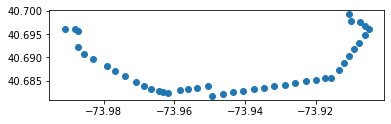

In [19]:
route_gdf.plot()